#### Laboratorio de LangGraph
Este notebook contiene notas de estudio para el framework de langGraph, desde lo mas basico a funciones mas avanzadas 

In [3]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from dotenv import load_dotenv
from IPython.display import Image, display
import gradio as gr
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
import random
import urllib.parse


load_dotenv(override=True)

True

##### Ejercicio 1
Definicio de un Grafo Simple que consta de una entrada, un nodo y una salida

el nodo corresponde a un chat simple hecho en gradio que responde con palabras aleatorias sin `LLM`.
Se utiliza el tipado + anotacion en python: `my_favorite_things: Annotated[list," estas son algunas de mis cosas favoritas "]` 
ya que Langgraph necesita que usemos esta función cuando definimos nuestro objeto de estado.
Quiere que le digamos qué función debe llamar para actualizar el estado con un nuevo valor.
Esta función se llama **reductor**.
Langgraph proporciona un reductor predeterminado llamado `add_messages` que se encarga del caso más común.
Y con suerte explica por qué el estado se ve así.

**Pasos para crear un grafo**
1. Definir el estado
2. incializar el constructor del grafo con el estado
3. creacion del nodo
4. creacion de aristas
5. compilzacion del nodo

In [ ]:
nouns = ["Coles", "Unicornios", "Tostadora", "Pinguinos", "Bananas", "Zombies", "Arcoiris", "Anguilas", "Pepinillos", "Muffins"]
adjectives = ["malos", "pedantes", "existenciales", "malhumorados", "brillantes", "desconfiados", "sarcásticos", "mollosos", "misteriosos"]

# Algunas funciones útiles

def get_random_noun():
    return random.choice(nouns)

def get_random_adjective():
    return random.choice(adjectives)

# 1.Definición del estado
class State(BaseModel):
    messages: Annotated[list, add_messages]

# 2.Inicialización del constructor del grafo
graph_builder = StateGraph(State)    

# 3. Creacion de nodo
def our_first_node(old_state: State) -> State:

    reply = f"{random.choice(nouns)} son {random.choice(adjectives)}"
    messages = [{"role": "assistant", "content": reply}]

    new_state = State(messages=messages)

    return new_state

graph_builder.add_node("first_node", our_first_node)

# 4. Creacion de aristas
graph_builder.add_edge(START, "first_node")
graph_builder.add_edge("first_node", END)

# 5. compilación del grafo
graph = graph_builder.compile()

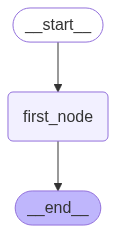

In [4]:
# Graficamos el nodo
display(Image(graph.get_graph().draw_mermaid_png()))

#### Ejecucion de un Grafo simple
Para ejecutar este grafo, se crea una funcion chat

In [5]:
def chat(user_input: str, history):
    message = {"role": "user", "content": user_input}
    messages = [message]
    state = State(messages=messages)
    result = graph.invoke(state)
    print(result)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='8fbd89a9-fe85-4b72-b246-a4dd3d0184f3'), AIMessage(content='Arcoiris son mollosos', additional_kwargs={}, response_metadata={}, id='bbb9e92e-ed8e-4083-b010-5d0a0f24f824')]}


### Adicionando LLM
Se adiciona un modelo de llm del provedor de preferencia

en este caso utilizamos `gemini`

para configurar diferentes proveedores consulte: https://langchain-ai.github.io/langgraph/tutorials/get-started/1-build-basic-chatbot/#2-create-a-stategraph

In [11]:
import os
from langchain.chat_models import init_chat_model

load_dotenv(override=True)

llm = init_chat_model("google_genai:gemini-2.0-flash")
print()

Creamos un chat  sin histórico !
esto debido a que solo vamos a crear un grafo y cada ves que enviemos una pregunta, langraph ejecutará un **Super Paso**

In [16]:
class State(BaseModel):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)    


def chatbot_node(old_state: State) -> State:
    response = llm.invoke(old_state.messages)
    new_state = State(messages=[response])
    return new_state

graph_builder.add_node("chatbot", chatbot_node)

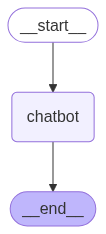

In [17]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
def chat(user_input: str, history):
    initial_state = State(messages=[{"role": "user", "content": user_input}])
    result = graph.invoke(initial_state)
    print(result)
    return result['messages'][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='adcc2d15-4a61-436a-923b-af9bebade1ce'), AIMessage(content='¡Hola! ¿En qué puedo ayudarte hoy? 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f6e7e554-ac61-4fa1-9303-c3727124f10e-0', usage_metadata={'input_tokens': 1, 'output_tokens': 12, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})]}
{'messages': [HumanMessage(content='quien eres', additional_kwargs={}, response_metadata={}, id='417738f8-d552-4811-81fc-1bf6bea43f14'), AIMessage(content='Soy un modelo de lenguaje grande, entrenado por Google.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--8bf0669b-e45b-4db3-914f-dcf40944d420-0', usage_

### Ejercicio 2

- Implementando LangSmit para observar la trazabilidad
- Implementando herramientas auto hosteadas como `GoogleSerperApiWrapper` para búsquedas
- Implementando herramientas propias

In [4]:
from langchain_community.utilities import GoogleSerperAPIWrapper

serper = GoogleSerperAPIWrapper()
serper.run("¿Cuál es la capital de Francia?")

'París (en francés:) es la capital de Francia y de la región de Isla de Francia. Es la ciudad más poblada del país y el único departamento unicomunal de Francia. La. capital de Francia es París. Sin embargo, esto no ha sido siempre así y en el curso de la historia, muchas ciudades se han convertido en capital ... Ciudad de París, Francia París, la capital de Francia, es famosa por su encanto romántico, sus lugares emblemáticos y su rico patrimonio ... Explora los encantos de París, la emblemática capital de Francia. Descubre su historia, cultura y los lugares más visitados. #paris #parís # ... París es la capital de Francia y su ciudad más poblada. Capital de la región de Isla de Francia, constituye el único departamento unicomunal del país. Descubre Paris, la ciudad más bonita del mundo, con Explora Planet. En este video, te llevamos en un recorrido inolvidable por los lugares ... París, la capital de Francia es y será la ciudad más bonita donde aprender francés al mismo tiempo que vi

In [5]:
from langchain.agents import Tool

#Clase contenedora para convertir la función en una herramienta de LangChain
tool_search =Tool(
        name="search",
        func=serper.run,
        description="Útil cuando necesitas más información de una búsqueda en línea."
    )

In [21]:
#invocamos la herramienta
tool_search.invoke("¿Cuál es la capital de Francia?")

'París (en francés:) es la capital de Francia y de la región de Isla de Francia. Es la ciudad más poblada del país y el único departamento unicomunal de ... La. capital de Francia es París. Sin embargo, esto no ha sido siempre así y en el curso de la historia, muchas ciudades se han convertido en capital ... París, la capital de Francia es y será la ciudad más bonita donde aprender francés al mismo tiempo que visita una ciudad rebosante de historia. ... Que Verás: Torre Eiffel: Conoce la historia y curiosidades de ... Francia. Por Qué Verlo: Datos y Curiosidades: Aprende sobre ... París es la capital de Francia y la ciudad más poblada del país, con una ... Sabías que ? Sabías que? Francia intentó invadir a México #CapCut ... Qué ver en París: conoce la capital de Francia · la ciudad de la Torre Eiffel · la Mona Lisa · el río Sena · la Catedral de Notre-Dame · los candados del amor ... País: Francia Capital: París Idioma: francés País miembro de la UE: desde 1958 Saludamos a #Francia en

##### Escribiendo una herramienta propia


In [6]:
def generate_link_whatsapp(mensaje=None):
  """Genera un link de WhatsApp con un mensaje predefinido."""
  numero = os.getenv('WHATSAPP_NUMBER', '')
  url_base = f"https://wa.me/{numero}"
  if mensaje:
    mensaje_codificado = urllib.parse.quote(mensaje)
    return f"{url_base}?text={mensaje_codificado}"
  else:
    return url_base
  

tool_generate_whatsapp_link = Tool(
    name="generate_whatsapp_link",
    func=generate_link_whatsapp,
    description="Genera un link de WhatsApp con un mensaje predefinido. Si no se proporciona un mensaje, genera un link vacío."
)  

Un pequeño cambio: usar TypedDict en lugar de BaseModel para el objeto State
Al implementar herramientas, siempre debemos realizar dos cambios en el código:
1. Cambios para proporcionar las herramientas a OpenAI en formato JSON al realizar la llamada.
2. Cambios para gestionar los resultados: buscar el modelo manteniendo el argumento finish_reason=="tool_calls" y luego recuperar la llamada, ejecutar la función y proporcionar los resultados.

In [7]:
from typing import TypedDict

In [8]:
#array de herramientas
tools = [tool_search, tool_generate_whatsapp_link]

### Creando el Grafo

In [12]:
# Paso 1: Definir el objeto Estado
class State(TypedDict):
    messages: Annotated[list, add_messages]

# Paso 2: Iniciar el constructor del Grafo con la clase Estado
graph_builder = StateGraph(State)

#agregamos las herramientas al agente
llm_with_tools = llm.bind_tools(tools)



In [ ]:
# Paso 3: Creamos un Nodo
from langgraph.prebuilt import ToolNode, tools_condition #utilidad de nodos para herramientas

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [12]:
# Paso 4: Creamos Aristas
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")

# Cada vez que se llama a una herramienta, volvemos al chatbot para decidir el siguiente paso.
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

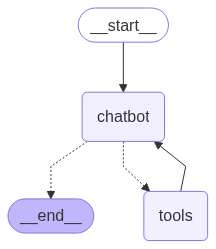

In [13]:
# Paso 5: Compilamos el Grafo
graph = graph_builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

### EJECUTAMOS UN CHAT !!

In [ ]:
def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]})
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

#### Adicionando Memoria
para adicionar una memoria a un grafo, en langgraph se usa el concepto de **CheckPoint**
el cual permite chequear un estado en un tiempo especifico de la ejecucion

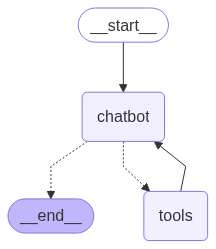

In [20]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

graph_builder = StateGraph(State)


# Step 3
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Step 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Step 5
graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
config = {"configurable": {"thread_id": "1"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='95a35e20-ca3d-4cea-9969-1961a5fbf036')]}
{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='95a35e20-ca3d-4cea-9969-1961a5fbf036'), AIMessage(content='Hola! Como puedo ayudarte?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--f808953e-11c3-4815-9d89-7fed9c9c2589-0', usage_metadata={'input_tokens': 60, 'output_tokens': 6, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='mi nombre es cristian', additional_kwargs={}, response_metadata={}, id='6643d582-e1d6-4b25-ba49-20f4995fb870')]}
{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='95a35e20-ca3d-4cea-9969-1961a5fbf036'), AIMessage(content='Hola! Como puedo ayudarte?', additional_kwargs={}


### Almacenamiento de datos SQL
Implementación de SQL Lite para almancenamiento de memoria de los flujos


In [14]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.prebuilt import ToolNode, tools_condition 

db_path = "memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)
sql_memory = SqliteSaver(conn)

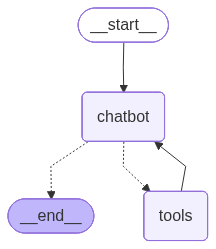

In [15]:
# Pasos 1 y 2
graph_builder = StateGraph(State)


# Paso 3
llm = init_chat_model("google_genai:gemini-2.0-flash")
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    print(state)
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

# Paso 4
graph_builder.add_conditional_edges( "chatbot", tools_condition, "tools")
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

# Paso 5
graph = graph_builder.compile(checkpointer=sql_memory)
display(Image(graph.get_graph().draw_mermaid_png()))
 

In [ ]:
config = {"configurable": {"thread_id": "3"}}

def chat(user_input: str, history):
    result = graph.invoke({"messages": [{"role": "user", "content": user_input}]}, config=config)
    return result["messages"][-1].content


gr.ChatInterface(chat, type="messages").launch()

* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


{'messages': [HumanMessage(content='hola', additional_kwargs={}, response_metadata={}, id='33842a20-f6d9-4d18-9107-3f941413cdf4'), AIMessage(content='Hola! Como puedo ayudarte?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--5c52c90c-448a-45d6-84ce-1d1cc78c1a19-0', usage_metadata={'input_tokens': 60, 'output_tokens': 6, 'total_tokens': 66, 'input_token_details': {'cache_read': 0}}), HumanMessage(content='me llamo cristian', additional_kwargs={}, response_metadata={}, id='abd887ec-51a1-4550-ab5d-64f6513fc0da'), AIMessage(content='Hola Cristian! En que te puedo ayudar hoy?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--7e114280-ee92-4a36-b263-b5f01562b1e0-0', usage_metadata={'input_tokens': 69, '